In [1]:
import numpy as np
from numpy.random import default_rng
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Rectangle
from scipy.stats import sem, pearsonr
from my_utils import *
from sklearn.linear_model import RidgeCV

from pathlib import Path
import sys
import warnings

In [2]:
modelpath = Path('../model')
sys.path.append(str(modelpath))
import config.config as config

In [3]:
# agents checkpoints path
progress_agents_path = Path('../data/agents_all')
# agents checkpoints performance path
training_curve_path = Path('../data/training_curve')
# figure path
figure_path = Path('../paper_figures/figure7')
# data path
analysis_data_path = Path('../data/analysis_data/figure7')

# Gain

In [4]:
arg = config.ConfigGain()
arg.device = 'cpu'
arg.process_gain_range = [3, 4.0001]

## Select agent checkpoints for analyses

In [5]:
from Actor1 import Actor as Actor1
from Actor3 import Actor as Actor3
from ActorEKF import Actor as ActorEKF
from Critic1 import Critic as Critic1
from Critic5 import Critic as Critic5

agent_archs = ['Actor1Critic1', 'ActorEKFCritic1', 'Actor3Critic5']
MAX_TRAINING_T = 1e5

In [6]:
def select_agents_all(progress_agents_path, agent_archs, MAX_TRAINING_T, tasks=['gain'], subtasks=[''], onlytrained=False):
    perform_files = [[pd.read_csv(file)[(pd.read_csv(file).episode > 0) & (pd.read_csv(file).episode < MAX_TRAINING_T)] 
                      for file in (training_curve_path / task / subtask).glob(f'{agent_arch}*.*')] 
                     for agent_arch, task, subtask in zip(agent_archs, tasks, subtasks)]
    
    seeds = [[''.join(filter(str.isdigit, file.stem.split('_')[1]))
              for file in (training_curve_path / task / subtask).glob(f'{agent_arch}*.*')] 
             for agent_arch, task, subtask in zip(agent_archs, tasks, subtasks)]
    
    agent_paths = []; agent_files = []
    for agent_arch, seeds_, task, subtask in zip(agent_archs, seeds, tasks, subtasks): # loop each agent
        agent_path = []; agent_file = []
        for seed in seeds_:
            perform_file_path = training_curve_path / task / subtask / f'{agent_arch}_seed{seed}.csv'
            perform_file = pd.read_csv(perform_file_path)
            perform_file = perform_file[(perform_file.episode > 0) & (perform_file.episode < MAX_TRAINING_T)]
            if not onlytrained:
                best_episode = perform_file.episode.unique()[np.sum([perform_file[perform_file.task == task].reward_rate 
                                        for task in perform_file.task.unique()], axis=0).argmax()]
            else:
                best_episode = perform_file.episode.unique()[np.sum([perform_file[perform_file.task == task].reward_rate 
                                        for task in perform_file.task.unique()
                                                                if task in ['gain1x', 'perturbation0']], axis=0).argmax()]
                
            task = task.replace('perturbation', 'gain')
            if 'full' in task:
                agent_path.append(progress_agents_path / agent_arch / '_'.join(task.split('_')[:-1]) / subtask / f'seed{seed}')
            else:
                agent_path.append(progress_agents_path / agent_arch / task / subtask / f'seed{seed}')
            agent_file.append(list(agent_path[-1].glob(f'*-{best_episode}.*'))[0].stem.split('.')[0])
        agent_paths.append(agent_path); agent_files.append(agent_file)
    
    
    return agent_paths, agent_files, perform_files

In [7]:
agent_paths, agent_files, perform_files = select_agents_all(progress_agents_path, agent_archs, 
                                                            MAX_TRAINING_T, 
                                                            tasks=['gain_full', 'gain_full', 'gain_full'], 
                                                            subtasks=['', '', ''])

In [8]:
agent_paths_1x, agent_files_1x, _ = select_agents_all(progress_agents_path, agent_archs, 
                                                      MAX_TRAINING_T, 
                                                      tasks=['gain_full', 'gain_full', 'gain_full'], 
                                                      subtasks=['', '', ''], onlytrained=True)

## Run agents

In [9]:
from Agent_RNN import *
from Environment import Env

In [10]:
def RNN_agent_simulation(agent, target_positions, gains, arg):
    reset_seeds(0)
    env = Env(arg)
    agent.bstep.obs_noise_range = arg.obs_noise_range

    pos_x = []; pos_x_end = []; pos_y = []; pos_y_end = []
    head_dir = []; head_dir_end = []; pos_r = []; pos_theta = []; pos_r_end = []; pos_theta_end = []; 
    pos_v = []; pos_w = []
    target_x = []; target_y = []; target_r = []; target_theta = []
    rewarded = []; relative_radius = []; relative_angle = []
    action_v = []; action_w = []
    relative_radius_end = []; relative_angle_end = []
    steps = []; state_ = []; action_ = []
    td_error = []

    for target_position, gain in zip(target_positions, gains):
        cross_start_threshold = False
        reward = torch.zeros(1, 1, 1)
        x = env.reset(target_position=target_position, pro_gains=gain)
        agent.bstep.reset(env.pro_gains)
        last_action = torch.zeros([1, 1, arg.ACTION_DIM])
        last_action_raw = last_action.clone()

        state = torch.cat([x[-arg.OBS_DIM:].view(1, 1, -1), last_action,
                           env.target_position_obs.view(1, 1, -1)], dim=2).to(arg.device)

        hidden_in = None

        true_states = []
        actions = []
        states = []
        rewards = []
        
        for t in range(arg.EPISODE_LEN):
            if not cross_start_threshold and (last_action_raw.abs() > arg.TERMINAL_ACTION).any():
                cross_start_threshold = True
                
            action, action_raw, hidden_out = agent.select_action(state, hidden_in, action_noise=None)
            next_x, reached_target, _ = env(x, action, t)
            next_ox = agent.bstep(next_x)
            next_state = torch.cat([next_ox.view(1, 1, -1), action,
                                    env.target_position_obs.view(1, 1, -1)], dim=2).to(arg.device)

            is_stop = env.is_stop(x, action)
            
            if is_stop and cross_start_threshold:
                reward = env.return_reward(x, reward_mode='mixed')

            true_states.append(x)
            states.append(state)
            actions.append(action)
            rewards.append(reward)

            if is_stop and cross_start_threshold:
                break
                
            last_action_raw = action_raw
            state = next_state
            x = next_x
            hidden_in = hidden_out

        # Trial end
        # TD errors
        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        dones = torch.zeros_like(rewards); dones[-1] = 1
        with torch.no_grad():
            Q = agent.critic.Q1(states, actions)
            next_Q = torch.zeros_like(Q); next_Q[:-1] = Q[1:]
            td_error_ = rewards + (1-dones) * arg.GAMMA * next_Q - Q
        
        td_error.append(abs(td_error_).mean().item())
        
        # other stuff
        pos_x_temp, pos_y_temp, head_dir_temp, pos_v_temp, pos_w_temp \
                    = torch.chunk(torch.cat(true_states, dim=1), x.shape[0], dim=0)
        pos_x.append(pos_x_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_y.append(pos_y_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_x_end.append(pos_x[-1][-1])
        pos_y_end.append(pos_y[-1][-1])
        head_dir.append(np.rad2deg(head_dir_temp.view(-1).numpy()))
        pos_v.append(pos_v_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_w.append(np.rad2deg(pos_w_temp.view(-1).numpy()))
        head_dir_end.append(head_dir[-1][-1])

        rho, phi = cart2pol(pos_x[-1], pos_y[-1])
        pos_r.append(rho)
        pos_theta.append(np.rad2deg(phi))
        pos_r_end.append(rho[-1])
        pos_theta_end.append(np.rad2deg(phi[-1]))

        target_x.append(target_position[0].item() * arg.LINEAR_SCALE)
        target_y.append(target_position[1].item() * arg.LINEAR_SCALE)
        tar_rho, tar_phi = cart2pol(target_x[-1], target_y[-1])
        target_r.append(tar_rho)
        target_theta.append(np.rad2deg(tar_phi))
        
        state_.append(states)

        action_.append(actions)
        action_v_temp, action_w_temp = torch.chunk(actions.squeeze(1), 
                                                   action.shape[-1], dim=1)
        action_v.append(action_v_temp.view(-1).numpy())
        action_w.append(action_w_temp.view(-1).numpy())
        
        relative_r, relative_ang = get_relative_r_ang(pos_x[-1], pos_y[-1], head_dir[-1], 
                                                      target_x[-1], target_y[-1])
        relative_radius.append(relative_r)
        relative_angle.append(np.rad2deg(relative_ang))
        relative_radius_end.append(relative_r[-1])
        relative_angle_end.append(np.rad2deg(relative_ang[-1]))
        rewarded.append((reached_target & is_stop).item())
        
        steps.append(np.arange(relative_r.size))

    agent.bstep.obs_noise_range = config.ConfigGain().obs_noise_range
    
    return(pd.DataFrame().assign(pos_x=pos_x, pos_y=pos_y, pos_x_end=pos_x_end, pos_y_end=pos_y_end,
                                 head_dir=head_dir, head_dir_end=head_dir_end, 
                                 pos_r=pos_r, pos_theta=pos_theta, 
                                 pos_r_end=pos_r_end, pos_theta_end=pos_theta_end, pos_v=pos_v, 
                                 pos_w=pos_w, target_x=target_x, target_y=target_y, 
                                 target_r=target_r,
                                 target_theta=target_theta, rewarded=rewarded,
                                 relative_radius=relative_radius, relative_angle=relative_angle,
                                 action_v=action_v, action_w=action_w, 
                                 relative_radius_end=relative_radius_end,
                                 relative_angle_end=relative_angle_end,
                                 steps=steps, gain_v=torch.stack(gains)[:, 0].numpy(),
                                 gain_w=torch.stack(gains)[:, 1].numpy(), 
                                 state=state_, action=action_, td_error=td_error))

In [11]:
def RNNEKF_agent_simulation(agent, target_positions, gains, arg):
    reset_seeds(0)
    env = Env(arg)
    agent.bstep.obs_noise_range = arg.obs_noise_range

    pos_x = []; pos_x_end = []; pos_y = []; pos_y_end = []
    head_dir = []; head_dir_end = []; pos_r = []
    pos_theta = []; pos_r_end = []; pos_theta_end = []; pos_v = []; pos_w = []
    target_x = []; target_y = []; target_r = []; target_theta = []
    rewarded = []; relative_radius = []; relative_angle = []
    action_v = []; action_w = []
    relative_radius_end = []; relative_angle_end = []
    steps = []; state_ = []; action_ = []
    td_error = []

    for target_position, gain in zip(target_positions, gains):
        cross_start_threshold = False
        reward = torch.zeros(1, 1, 1)
        x = env.reset(target_position=target_position, pro_gains=gain)
        b, EKFstate = agent.bstep.reset(env.pro_gains, env.pro_noise_std, env.target_position)
        EKFstate = EKFstate.to(arg.device).unsqueeze(0)
        last_action = torch.zeros([1, 1, arg.ACTION_DIM])
        last_action_raw = last_action.clone()

        state = torch.cat([x[-arg.OBS_DIM:].view(1, 1, -1), last_action,
                           env.target_position_obs.view(1, 1, -1)], dim=2).to(arg.device)

        true_states = []
        actions = []
        states = []
        EKFstates = []
        rewards = []
        
        for t in range(arg.EPISODE_LEN):
            if not cross_start_threshold and (last_action_raw.abs() > arg.TERMINAL_ACTION).any():
                cross_start_threshold = True
                
            action, action_raw = agent.select_action(EKFstate, action_noise=None)
            next_x, reached_target, _ = env(x, action, t)
            next_ox = agent.bstep.observation(next_x)
            next_state = torch.cat([next_ox.view(1, 1, -1), action,
                                    env.target_position_obs.view(1, 1, -1)], dim=2).to(arg.device)
            next_b = agent.bstep(b, next_ox, action, env.perturbation_vt, env.perturbation_wt)
            next_EKFstate = agent.bstep.b_reshape(next_b).to(arg.device).unsqueeze(0)

            is_stop = env.is_stop(x, action)
            if is_stop and cross_start_threshold:
                reward = env.return_reward(x, reward_mode='mixed')

            true_states.append(x)
            states.append(state)
            EKFstates.append(EKFstate)
            actions.append(action)
            rewards.append(reward)
            
            last_action_raw = action_raw
            state = next_state
            EKFstate = next_EKFstate
            x = next_x
            b = next_b

            if is_stop and cross_start_threshold:
                break

        # Trial end
        # TD errors
        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        dones = torch.zeros_like(rewards); dones[-1] = 1
        with torch.no_grad():
            Q = agent.critic.Q1(states, actions)
            next_Q = torch.zeros_like(Q); next_Q[:-1] = Q[1:]
            td_error_ = rewards + (1-dones) * arg.GAMMA * next_Q - Q
        
        td_error.append(abs(td_error_).mean().item())
        
        # other stuff
        pos_x_temp, pos_y_temp, head_dir_temp, pos_v_temp, pos_w_temp \
                    = torch.chunk(torch.cat(true_states, dim=1), x.shape[0], dim=0)
        pos_x.append(pos_x_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_y.append(pos_y_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_x_end.append(pos_x[-1][-1])
        pos_y_end.append(pos_y[-1][-1])
        head_dir.append(np.rad2deg(head_dir_temp.view(-1).numpy()))
        pos_v.append(pos_v_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_w.append(np.rad2deg(pos_w_temp.view(-1).numpy()))
        head_dir_end.append(head_dir[-1][-1])

        rho, phi = cart2pol(pos_x[-1], pos_y[-1])
        pos_r.append(rho)
        pos_theta.append(np.rad2deg(phi))
        pos_r_end.append(rho[-1])
        pos_theta_end.append(np.rad2deg(phi[-1]))

        target_x.append(target_position[0].item() * arg.LINEAR_SCALE)
        target_y.append(target_position[1].item() * arg.LINEAR_SCALE)
        tar_rho, tar_phi = cart2pol(target_x[-1], target_y[-1])
        target_r.append(tar_rho)
        target_theta.append(np.rad2deg(tar_phi))

        state_.append(torch.cat(EKFstates))
        
        action_.append(actions)
        action_v_temp, action_w_temp = torch.chunk(actions.squeeze(1), 
                                                   action.shape[-1], dim=1)
        action_v.append(action_v_temp.view(-1).numpy())
        action_w.append(action_w_temp.view(-1).numpy())

        relative_r, relative_ang = get_relative_r_ang(pos_x[-1], pos_y[-1], head_dir[-1], 
                                                      target_x[-1], target_y[-1])
        relative_radius.append(relative_r)
        relative_angle.append(np.rad2deg(relative_ang))
        relative_radius_end.append(relative_r[-1])
        relative_angle_end.append(np.rad2deg(relative_ang[-1]))
        rewarded.append((reached_target & is_stop).item())
        
        steps.append(np.arange(relative_r.size))

    return(pd.DataFrame().assign(pos_x=pos_x, pos_y=pos_y, pos_x_end=pos_x_end, pos_y_end=pos_y_end,
                                 head_dir=head_dir, head_dir_end=head_dir_end, 
                                 pos_r=pos_r, pos_theta=pos_theta, 
                                 pos_r_end=pos_r_end, pos_theta_end=pos_theta_end, pos_v=pos_v, 
                                 pos_w=pos_w, target_x=target_x, target_y=target_y, 
                                 target_r=target_r,
                                 target_theta=target_theta, rewarded=rewarded,
                                 relative_radius=relative_radius, relative_angle=relative_angle,
                                 action_v=action_v, action_w=action_w, 
                                 relative_radius_end=relative_radius_end,
                                 relative_angle_end=relative_angle_end,
                                 steps=steps, state=state_, action=action_, td_error=td_error))

In [12]:
SAMPLE_SIZE = 2000

reset_seeds(0)
env = Env(arg)
target_positions = []
gains = []

for _ in range(SAMPLE_SIZE):
    __ = env.reset()
    target_positions.append(env.target_position)
    gains.append(env.pro_gains)

In [13]:
agents_all = []
for idx, agent_arch in enumerate(agent_archs):
    agents_ = []
    for agent_path, agent_file in zip(agent_paths[idx], agent_files[idx]):
        if idx == 1:
            from Agent_RNN_EKF import *
            agent = Agent(arg, eval(agent_arch[:8]), eval(agent_arch[8:]))
        else:
            from Agent_RNN import *
            agent = Agent(arg, eval(agent_arch[:6]), eval(agent_arch[6:]))
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
    agents_all.append(agents_)

In [14]:
agent_trajectories_all = [[RNNEKF_agent_simulation(agent, target_positions, gains, arg) for agent in agents_] if idx == 1
                          else [RNN_agent_simulation(agent, target_positions, gains, arg) for agent in agents_]
                          for idx, agents_ in enumerate(agents_all)]

In [15]:
gains_1x = [arg.process_gain_default for _ in range(len(gains))]

agents_all_1x = []
for idx, agent_arch in enumerate(agent_archs):
    agents_ = []
    for agent_path, agent_file in zip(agent_paths_1x[idx], agent_files_1x[idx]):
        if idx == 1:
            from Agent_RNN_EKF import *
            agent = Agent(arg, eval(agent_arch[:8]), eval(agent_arch[8:]))
        else:
            from Agent_RNN import *
            agent = Agent(arg, eval(agent_arch[:6]), eval(agent_arch[6:]))
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
    agents_all_1x.append(agents_)

In [16]:
agent_trajectories_1x = [[RNNEKF_agent_simulation(agent, target_positions, gains_1x, arg) for agent in agents_] if idx == 1
                          else [RNN_agent_simulation(agent, target_positions, gains_1x, arg) for agent in agents_]
                          for idx, agents_ in enumerate(agents_all_1x)]

## Figures

In [19]:
locals().update(config_colors())
major_formatter = FuncFormatter(my_tickformatter)

fontsize = 7
lw = 1

## S8a

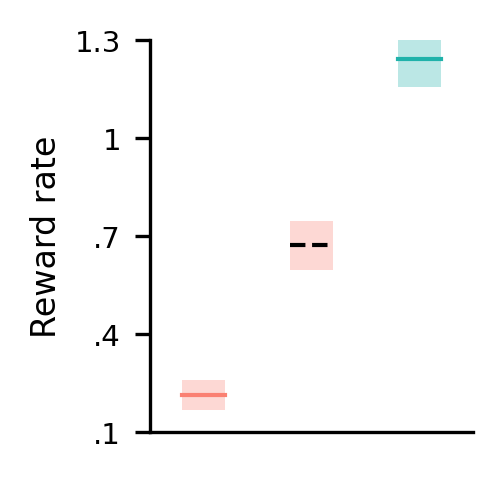

In [23]:
width = 1.5; height = 1.4
yticks = np.around(np.linspace(0.1, 1.3, 5), 1)
colors1 = [holistic_c, 'k', modular_c]
colors2 = [holistic_c, holistic_c, modular_c]

xticks = np.arange(3)

fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks([], fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Reward rate', fontsize=fontsize+1)
ax.set_xlim(xticks[0]-0.5, xticks[-1]+0.5)
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_label_coords(-0.27, 0.5)
ax.yaxis.set_major_formatter(major_formatter)

meandata = np.array([np.mean([df.rewarded.sum() / (np.sum([d.pos_x.size - 1 for d in df.itertuples()]) * arg.DT) 
                              for df in dfs]) for dfs in agent_trajectories_all])
semdata = np.array([sem([df.rewarded.sum() / (np.sum([d.pos_x.size - 1 for d in df.itertuples()]) * arg.DT) 
                         for df in dfs]) for dfs in agent_trajectories_all])


for x, ymean, ysem, c1, c2, ls in zip(xticks, meandata, semdata, colors1, colors2, ['-', '--', '-']):
    ax.plot([x-0.2, x+0.2], [ymean, ymean], c=c1, lw=lw, ls=ls)
    ax.fill_between([x-0.2, x+0.2], [ymean - ysem] * 2, [ymean + ysem] * 2, 
                    facecolor=c2, alpha=0.3)

fig.tight_layout(pad=0, rect=[0.015, 0, 1.015, 1])
#plt.savefig(figure_path / 'raw/{name}.pdf'.format(
#                 name='reward_rate_gain'), orientation='portrait', format='pdf', transparent=True)

In [24]:
targets = agent_trajectories_all[0][0][['target_x', 'target_y']].values
shuffled_targets = targets.copy()
rng = default_rng(1); rng.shuffle(shuffled_targets, axis=0)

ydata_subjects = []; xdata_subjects = []
for dfs in agent_trajectories_all:
    ydata_seeds = []; xdata_seeds = []
    for df in dfs:
        ydata = []; xdata = []
        dr = np.linalg.norm(df[['pos_x_end', 'pos_y_end']].values - targets, axis=1)
        dr_shuffled = np.linalg.norm(df[['pos_x_end', 'pos_y_end']].values - shuffled_targets, axis=1) 
        hypo_reward_boundaries = np.arange(round(max(max(dr), max(dr_shuffled))) + 2)
        for reward_boundary in hypo_reward_boundaries:
            ydata.append((dr < reward_boundary).sum() / len(df))
            xdata.append((dr_shuffled < reward_boundary).sum() / len(df))
        ydata_seeds.append(ydata); xdata_seeds.append(xdata)
    ydata_subjects.append(ydata_seeds); xdata_subjects.append(xdata_seeds)
    
    
auc_data = [[np.trapz(ydata_subjects[agent_idx][idx], xdata_subjects[agent_idx][idx]) 
             for idx in range(len(agent_trajectories_all[agent_idx]))] 
            for agent_idx in range(len(agent_trajectories_all))]
auc_mean = np.array([np.mean(i) for i in auc_data])
auc_sem = np.array([sem(i) for i in auc_data])

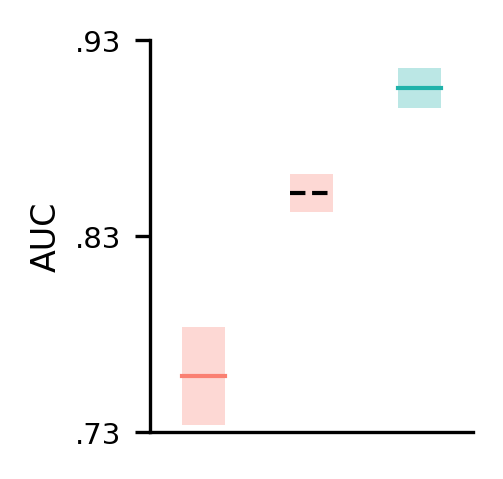

In [25]:
width = 1.5; height = 1.4
yticks = np.around(np.linspace(0.73, 0.93, 3), 2)

xticks = np.arange(3)

fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks([], fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('AUC', fontsize=fontsize+1)
ax.set_xlim(xticks[0]-0.5, xticks[-1]+0.5)
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_label_coords(-0.27, 0.5)
ax.yaxis.set_major_formatter(major_formatter)

for x, ymean, ysem, c1, c2, ls in zip(xticks, auc_mean, auc_sem, colors1, colors2, ['-', '--', '-']):
    ax.plot([x-0.2, x+0.2], [ymean, ymean], c=c1, lw=lw, ls=ls)
    ax.fill_between([x-0.2, x+0.2], [ymean - ysem] * 2, [ymean + ysem] * 2, 
                    facecolor=c2, alpha=0.3)

fig.tight_layout(pad=0, rect=[0.015, 0, 1.015, 1])
#plt.savefig(figure_path / 'raw/{name}.pdf'.format(
#                 name='AUC_gain'), orientation='portrait', format='pdf', transparent=True)

In [26]:
def compute_curvature(dfs, stack_trials=True):
    arg = config.ConfigCore()
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        dfs = [dfs] if not isinstance(dfs, list) else dfs
        curvs = []
        for df in dfs:
            if 'gain_v' not in df.columns:
                linear_scale = 1
                df_ = df
                x_key = 'pos_x'; y_key = 'pos_y'
            else:
                if (df.gain_v > 100).any():  # monkey df
                    linear_scale = arg.LINEAR_SCALE
                    df_ = downsample(df)
                    x_key = 'pos_x_ds'; y_key = 'pos_y_ds'
                else:
                    linear_scale = 1
                    df_ = df
                    x_key = 'pos_x'; y_key = 'pos_y'

            curv = []
            for _, trial in df_.iterrows():
                dx = np.gradient(trial[x_key] * linear_scale); ddx = np.gradient(dx)
                dy = np.gradient(trial[y_key] * linear_scale); ddy = np.gradient(dy)
                curv_ = abs(dx * ddy - dy * ddx) / (dx**2 + dy**2)**(3 / 2)
                curv_ = curv_[(~np.isnan(curv_))]
                if curv_.size > 0:
                    curv_ = curv_[curv_ < np.percentile(curv_, 95)]
                    curv.append(curv_)

            curvs.append(np.hstack(curv)) if stack_trials else curvs.append(curv)
    return curvs

In [27]:
curvs_mean = [np.mean([v.mean() for v in compute_curvature(agent_trajectories, stack_trials=True)]) 
              for agent_trajectories in agent_trajectories_all]
curvs_sem = [sem([v.mean() for v in compute_curvature(agent_trajectories, stack_trials=True)]) 
             for agent_trajectories in agent_trajectories_all]

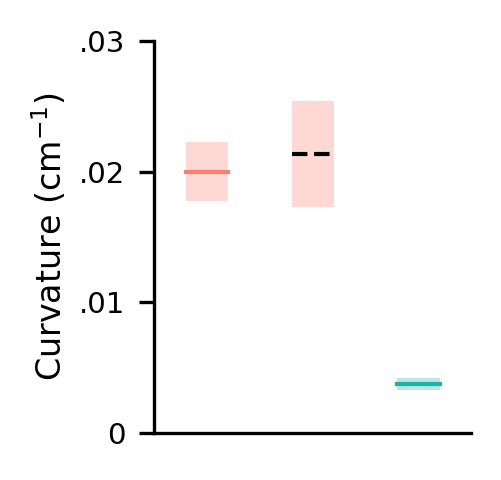

In [28]:
width = 1.5; height = 1.4
yticks = np.around(np.linspace(0, 0.03, 4), 2)

xticks = np.arange(3)

fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks([], fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Curvature (cm$^{-1}$)', fontsize=fontsize+1)
ax.set_xlim(xticks[0]-0.5, xticks[-1]+0.5)
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_label_coords(-0.27, 0.5)
ax.yaxis.set_major_formatter(major_formatter)

for x, ymean, ysem, c1, c2, ls in zip(xticks, curvs_mean, curvs_sem, colors1, colors2, ['-', '--', '-']):
    ax.plot([x-0.2, x+0.2], [ymean, ymean], c=c1, lw=lw, ls=ls)
    ax.fill_between([x-0.2, x+0.2], [ymean - ysem] * 2, [ymean + ysem] * 2, 
                    facecolor=c2, alpha=0.3)

fig.tight_layout(pad=0, rect=[0.015, 0, 1.015, 1])
#plt.savefig(figure_path / 'raw/{name}.pdf'.format(
#    name='curvature_gain'), orientation='portrait', format='pdf', transparent=True)

In [29]:
def compute_length(dfs):
    arg = config.ConfigCore()
    dfs = [dfs] if not isinstance(dfs, list) else dfs
    lengths = []
    for df in dfs:
        if 'gain_v' not in df.columns:
            linear_scale = 1
            df_ = df
            x_key = 'pos_x'; y_key = 'pos_y'
        else:
            if (df.gain_v > 100).any():  # monkey df
                linear_scale = arg.LINEAR_SCALE
                df_ = downsample(df)
                x_key = 'pos_x_ds'; y_key = 'pos_y_ds'
            else:
                linear_scale = 1
                df_ = df
                x_key = 'pos_x'; y_key = 'pos_y'

        length = []
        for _, trial in df_.iterrows():
            dx = np.diff(trial[x_key] * linear_scale)
            dy = np.diff(trial[y_key] * linear_scale)
            length.append((np.sqrt(dx**2 + dy**2)).sum())
        lengths.append(np.hstack(length))
    return lengths

In [30]:
lengths_mean = [np.mean([v.mean() for v in compute_length(agent_trajectories)]) 
              for agent_trajectories in agent_trajectories_all]
lengths_sem = [sem([v.mean() for v in compute_length(agent_trajectories)]) 
             for agent_trajectories in agent_trajectories_all]

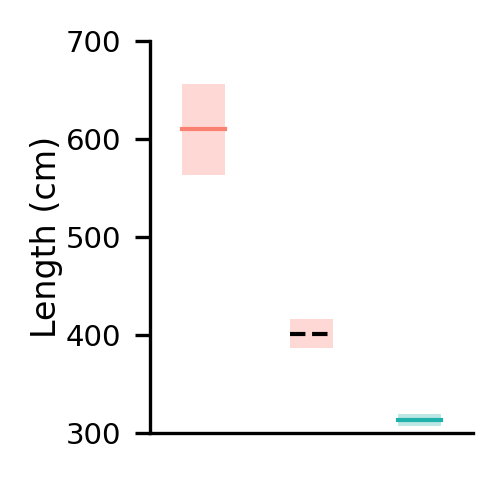

In [31]:
width = 1.5; height = 1.4
yticks = np.linspace(300, 700, 5)

xticks = np.arange(3)

fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks([], fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Length (cm)', fontsize=fontsize+1)
ax.set_xlim(xticks[0]-0.5, xticks[-1]+0.5)
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_label_coords(-0.27, 0.5)
ax.yaxis.set_major_formatter(major_formatter)

for x, ymean, ysem, c1, c2, ls in zip(xticks, lengths_mean, lengths_sem, colors1, colors2, ['-', '--', '-']):
    ax.plot([x-0.2, x+0.2], [ymean, ymean], c=c1, lw=lw, ls=ls)
    ax.fill_between([x-0.2, x+0.2], [ymean - ysem] * 2, [ymean + ysem] * 2, 
                    facecolor=c2, alpha=0.3)

fig.tight_layout(pad=0, rect=[0.015, 0, 1.015, 1])
#plt.savefig(figure_path / 'raw/{name}.pdf'.format(
#                 name='length_gain'), orientation='portrait', format='pdf', transparent=True)

# Perturbation

In [32]:
arg_pert = config.ConfigPerturb()
arg_pert.device = 'cpu'
arg_pert.perturbation_velocity_range = np.hstack([np.array([-400, 800]) / arg.LINEAR_SCALE, 
                                                            np.deg2rad([-180, 180])])

## Select agent checkpoints for analyses

In [33]:
def select_agents_all(progress_agents_path, agent_archs, MAX_TRAINING_T, tasks=['gain'], subtasks=[''], onlytrained=False):
    perform_files = [[pd.read_csv(file)[(pd.read_csv(file).episode > 0) & (pd.read_csv(file).episode < MAX_TRAINING_T)] 
                      for file in (training_curve_path / task / subtask).glob(f'{agent_arch}*.*')] 
                     for agent_arch, task, subtask in zip(agent_archs, tasks, subtasks)]
    
    seeds = [[''.join(filter(str.isdigit, file.stem.split('_')[1]))
              for file in (training_curve_path / task / subtask).glob(f'{agent_arch}*.*')] 
             for agent_arch, task, subtask in zip(agent_archs, tasks, subtasks)]
    
    agent_paths = []; agent_files = []
    for agent_arch, seeds_, task, subtask in zip(agent_archs, seeds, tasks, subtasks): # loop each agent
        agent_path = []; agent_file = []
        for seed in seeds_:
            perform_file_path = training_curve_path / task / subtask / f'{agent_arch}_seed{seed}.csv'
            perform_file = pd.read_csv(perform_file_path)
            perform_file = perform_file[(perform_file.episode > 0) & (perform_file.episode < MAX_TRAINING_T)]
            #print(perform_file)
            if not onlytrained:
                best_episode = perform_file.episode.unique()[np.sum([perform_file[perform_file.task == task].reward_rate 
                                        for task in perform_file.task.unique()], axis=0).argmax()]
            else:
                best_episode = perform_file.episode.unique()[np.sum([perform_file[perform_file.task == task].reward_rate 
                                        for task in perform_file.task.unique()
                                                                if task in ['gain1x', 'perturbation0']], axis=0).argmax()]
                
            task_ = task.replace('perturbation', 'gain')
            if 'full' in task:
                agent_path.append(progress_agents_path / agent_arch / '_'.join(task_.split('_')[:-1]) / subtask / f'seed{seed}')
            else:
                agent_path.append(progress_agents_path / agent_arch / task_ / subtask / f'seed{seed}')
            agent_file.append(list(agent_path[-1].glob(f'*-{best_episode}.*'))[0].stem.split('.')[0])
        agent_paths.append(agent_path); agent_files.append(agent_file)
    
    
    return agent_paths, agent_files, perform_files

In [34]:
agent_paths_pert, agent_files_pert, perform_files_pert = select_agents_all(progress_agents_path, agent_archs, MAX_TRAINING_T,
                       tasks=['perturbation_full', 'perturbation_full', 'perturbation_full'], 
                       subtasks=['', '', ''])

## Run agents in the perturbation task

In [35]:
def RNN_agent_simulation_pert(arg, agent, target_positions, perturb_peaks, perturb_start_time_oris):
    reset_seeds(0)
    env = Env(arg)
    agent.bstep.obs_noise_range = arg.obs_noise_range

    pos_x = []; pos_y = []; pos_x_end = []; pos_y_end = []; head_dir = []; head_dir_end = []; pos_r = []
    pos_theta = []; pos_r_end = []; pos_theta_end = []; pos_v = []; pos_w = []
    target_x = []; target_y = []; target_r = []; target_theta = []
    rewarded = []; relative_radius = []; relative_angle = []
    action_v = []; action_w = []
    relative_radius_end = []; relative_angle_end = []; steps = []
    perturb_v = []; perturb_w = []; perturb_v_gauss = []; perturb_w_gauss = []
    state_ = []; action_ = []
    td_error = []

    for target_position, perturb_peak, perturb_start_time_ori in zip(target_positions, perturb_peaks,
                                                                          perturb_start_time_oris):
        cross_start_threshold = False
        reward = torch.zeros(1, 1, 1)
        x = env.reset(target_position=target_position, perturbation_velocities=perturb_peak,
                      perturbation_start_t=perturb_start_time_ori)
        agent.bstep.reset(env.pro_gains)
        last_action = torch.zeros([1, 1, arg.ACTION_DIM])
        last_action_raw = last_action.clone()

        state = torch.cat([x[-arg.OBS_DIM:].view(1, 1, -1), last_action,
                           env.target_position.view(1, 1, -1)], dim=2).to(arg.device)

        hidden_in = None

        true_states = []
        actions = []
        states = []
        rewards = []
        perturbations = []
        
        for t in range(arg.EPISODE_LEN):
            if not cross_start_threshold and (last_action_raw.abs() > arg.TERMINAL_ACTION).any():
                cross_start_threshold = True
            
            action, action_raw, hidden_out = agent.select_action(state, hidden_in, action_noise=None)
            next_x, reached_target, _ = env(x, action, t)
            next_ox = agent.bstep(next_x)
            next_state = torch.cat([next_ox.view(1, 1, -1), action,
                                    env.target_position_obs.view(1, 1, -1)], dim=2).to(arg.device)

            is_stop = env.is_stop(x, action)
            
            if is_stop and cross_start_threshold:
                reward = env.return_reward(x, reward_mode='mixed')

            true_states.append(x)
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            perturbations.append(torch.stack((env.perturbation_vt, env.perturbation_wt)))

            if is_stop and cross_start_threshold:
                break
                
            last_action_raw = action_raw
            state = next_state
            x = next_x
            hidden_in = hidden_out

        # Trial end
        # TD errors
        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        dones = torch.zeros_like(rewards); dones[-1] = 1
        with torch.no_grad():
            Q = agent.critic.Q1(states, actions)
            next_Q = torch.zeros_like(Q); next_Q[:-1] = Q[1:]
            td_error_ = rewards + (1-dones) * arg.GAMMA * next_Q - Q
        
        td_error.append(abs(td_error_).mean().item())
        # others
        pos_x_temp, pos_y_temp, head_dir_temp, pos_v_temp, pos_w_temp \
                    = torch.chunk(torch.cat(true_states, dim=1), x.shape[0], dim=0)
        pos_x.append(pos_x_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_y.append(pos_y_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_x_end.append(pos_x[-1][-1])
        pos_y_end.append(pos_y[-1][-1])
        head_dir.append(np.rad2deg(head_dir_temp.view(-1).numpy()))
        pos_v.append(pos_v_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_w.append(np.rad2deg(pos_w_temp.view(-1).numpy()))
        head_dir_end.append(head_dir[-1][-1])

        rho, phi = cart2pol(pos_x[-1], pos_y[-1])
        pos_r.append(rho)
        pos_theta.append(np.rad2deg(phi))
        pos_r_end.append(rho[-1])
        pos_theta_end.append(np.rad2deg(phi[-1]))

        target_x.append(target_position[0].item() * arg.LINEAR_SCALE)
        target_y.append(target_position[1].item() * arg.LINEAR_SCALE)
        tar_rho, tar_phi = cart2pol(target_x[-1], target_y[-1])
        target_r.append(tar_rho)
        target_theta.append(np.rad2deg(tar_phi))
        
        state_.append(states)

        action_.append(actions)
        action_v_temp, action_w_temp = torch.chunk(actions.squeeze(1), 
                                                   action.shape[-1], dim=1)
        action_v.append(action_v_temp.view(-1).numpy())
        action_w.append(action_w_temp.view(-1).numpy())
        
        relative_r, relative_ang = get_relative_r_ang(pos_x[-1], pos_y[-1], head_dir[-1], 
                                                      target_x[-1], target_y[-1])
        relative_radius.append(relative_r)
        relative_angle.append(np.rad2deg(relative_ang))
        relative_radius_end.append(relative_r[-1])
        relative_angle_end.append(np.rad2deg(relative_ang[-1]))
        rewarded.append((reached_target & is_stop).item())
        
        steps.append(np.arange(relative_r.size))
        
        perturb_v.append(torch.stack(perturbations)[:, 0].numpy() * arg.LINEAR_SCALE)
        perturb_w.append(np.rad2deg(torch.stack(perturbations)[:, 1].numpy()))
        perturb_v_gauss.append(env.gaussian_v_array.numpy() * arg.LINEAR_SCALE)
        perturb_w_gauss.append(np.rad2deg(env.gaussian_w_array.numpy()))
        
    agent.bstep.obs_noise_range = config.ConfigGain().obs_noise_range

    return(pd.DataFrame().assign(pos_x=pos_x, pos_y=pos_y, pos_x_end=pos_x_end, pos_y_end=pos_y_end, 
                                 head_dir=head_dir, head_dir_end=head_dir_end, 
                                 pos_r=pos_r, pos_theta=pos_theta, 
                                 pos_r_end=pos_r_end, pos_theta_end=pos_theta_end, pos_v=pos_v, 
                                 pos_w=pos_w, target_x=target_x, target_y=target_y, 
                                 target_r=target_r,
                                 target_theta=target_theta, rewarded=rewarded,
                                 relative_radius=relative_radius, relative_angle=relative_angle,
                                 action_v=action_v, action_w=action_w, 
                                 relative_radius_end=relative_radius_end,
                                 relative_angle_end=relative_angle_end, steps=steps,
                                 perturb_v=perturb_v, perturb_w=perturb_w,
                                 perturb_vpeak=torch.stack(perturb_peaks)[:, 0].numpy() * arg.LINEAR_SCALE,
                                 perturb_wpeak=np.rad2deg(torch.stack(perturb_peaks)[:, 1].numpy()),
                                 perturb_start_time=torch.stack(perturb_start_time_oris).numpy(),
                                 perturb_v_gauss=perturb_v_gauss, perturb_w_gauss=perturb_w_gauss,
                                 gain_v=[env.process_gain_default[0].item() for _ in range(len(pos_x))],
                                 gain_w=[env.process_gain_default[1].item() for _ in range(len(pos_x))],
                                 state=state_, action=action_, td_error=td_error))

In [36]:
def RNNEKF_agent_simulation_pert(arg, agent, target_positions, perturb_peaks, perturb_start_time_oris):
    reset_seeds(0)
    env = Env(arg)
    agent.bstep.obs_noise_range = arg.obs_noise_range

    pos_x = []; pos_x_end = []; pos_y = []; pos_y_end = []
    head_dir = []; head_dir_end = []; pos_r = []
    pos_theta = []; pos_r_end = []; pos_theta_end = []; pos_v = []; pos_w = []
    target_x = []; target_y = []; target_r = []; target_theta = []
    rewarded = []; relative_radius = []; relative_angle = []
    action_v = []; action_w = []
    relative_radius_end = []; relative_angle_end = []
    steps = []; state_ = []; action_ = []
    td_error = []

    for target_position, perturb_peak, perturb_start_time_ori in zip(target_positions, perturb_peaks,
                                                                     perturb_start_time_oris):
        cross_start_threshold = False
        reward = torch.zeros(1, 1, 1)
        x = env.reset(target_position=target_position, perturbation_velocities=perturb_peak,
                      perturbation_start_t=perturb_start_time_ori)
        b, EKFstate = agent.bstep.reset(env.pro_gains, env.pro_noise_std, env.target_position)
        EKFstate = EKFstate.to(arg.device).unsqueeze(0)
        last_action = torch.zeros([1, 1, arg.ACTION_DIM])
        last_action_raw = last_action.clone()

        state = torch.cat([x[-arg.OBS_DIM:].view(1, 1, -1), last_action,
                           env.target_position_obs.view(1, 1, -1)], dim=2).to(arg.device)

        true_states = []
        actions = []
        states = []
        EKFstates = []
        rewards = []
        
        for t in range(arg.EPISODE_LEN):
            if not cross_start_threshold and (last_action_raw.abs() > arg.TERMINAL_ACTION).any():
                cross_start_threshold = True
                
            action, action_raw = agent.select_action(EKFstate, action_noise=None)
            next_x, reached_target, _ = env(x, action, t)
            next_ox = agent.bstep.observation(next_x)
            next_state = torch.cat([next_ox.view(1, 1, -1), action,
                                    env.target_position_obs.view(1, 1, -1)], dim=2).to(arg.device)
            next_b = agent.bstep(b, next_ox, action, env.perturbation_vt, env.perturbation_wt)
            next_EKFstate = agent.bstep.b_reshape(next_b).to(arg.device).unsqueeze(0)

            is_stop = env.is_stop(x, action)
            if is_stop and cross_start_threshold:
                reward = env.return_reward(x, reward_mode='mixed')

            true_states.append(x)
            states.append(state)
            EKFstates.append(EKFstate)
            actions.append(action)
            rewards.append(reward)
            
            last_action_raw = action_raw
            state = next_state
            EKFstate = next_EKFstate
            x = next_x
            b = next_b

            if is_stop and cross_start_threshold:
                break

        # Trial end
        # TD errors
        states = torch.cat(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        dones = torch.zeros_like(rewards); dones[-1] = 1
        with torch.no_grad():
            Q = agent.critic.Q1(states, actions)
            next_Q = torch.zeros_like(Q); next_Q[:-1] = Q[1:]
            td_error_ = rewards + (1-dones) * arg.GAMMA * next_Q - Q
        
        td_error.append(abs(td_error_).mean().item())
        
        # other stuff
        pos_x_temp, pos_y_temp, head_dir_temp, pos_v_temp, pos_w_temp \
                    = torch.chunk(torch.cat(true_states, dim=1), x.shape[0], dim=0)
        pos_x.append(pos_x_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_y.append(pos_y_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_x_end.append(pos_x[-1][-1])
        pos_y_end.append(pos_y[-1][-1])
        head_dir.append(np.rad2deg(head_dir_temp.view(-1).numpy()))
        pos_v.append(pos_v_temp.view(-1).numpy() * arg.LINEAR_SCALE)
        pos_w.append(np.rad2deg(pos_w_temp.view(-1).numpy()))
        head_dir_end.append(head_dir[-1][-1])

        rho, phi = cart2pol(pos_x[-1], pos_y[-1])
        pos_r.append(rho)
        pos_theta.append(np.rad2deg(phi))
        pos_r_end.append(rho[-1])
        pos_theta_end.append(np.rad2deg(phi[-1]))

        target_x.append(target_position[0].item() * arg.LINEAR_SCALE)
        target_y.append(target_position[1].item() * arg.LINEAR_SCALE)
        tar_rho, tar_phi = cart2pol(target_x[-1], target_y[-1])
        target_r.append(tar_rho)
        target_theta.append(np.rad2deg(tar_phi))

        state_.append(torch.cat(EKFstates))
        
        action_.append(actions)
        action_v_temp, action_w_temp = torch.chunk(actions.squeeze(1), 
                                                   action.shape[-1], dim=1)
        action_v.append(action_v_temp.view(-1).numpy())
        action_w.append(action_w_temp.view(-1).numpy())

        relative_r, relative_ang = get_relative_r_ang(pos_x[-1], pos_y[-1], head_dir[-1], 
                                                      target_x[-1], target_y[-1])
        relative_radius.append(relative_r)
        relative_angle.append(np.rad2deg(relative_ang))
        relative_radius_end.append(relative_r[-1])
        relative_angle_end.append(np.rad2deg(relative_ang[-1]))
        rewarded.append((reached_target & is_stop).item())
        
        steps.append(np.arange(relative_r.size))

    return(pd.DataFrame().assign(pos_x=pos_x, pos_y=pos_y, pos_x_end=pos_x_end, pos_y_end=pos_y_end,
                                 head_dir=head_dir, head_dir_end=head_dir_end, 
                                 pos_r=pos_r, pos_theta=pos_theta, 
                                 pos_r_end=pos_r_end, pos_theta_end=pos_theta_end, pos_v=pos_v, 
                                 pos_w=pos_w, target_x=target_x, target_y=target_y, 
                                 target_r=target_r,
                                 target_theta=target_theta, rewarded=rewarded,
                                 relative_radius=relative_radius, relative_angle=relative_angle,
                                 action_v=action_v, action_w=action_w, 
                                 relative_radius_end=relative_radius_end,
                                 relative_angle_end=relative_angle_end,
                                 steps=steps, state=state_, action=action_, td_error=td_error))

In [37]:
reset_seeds(0)

env = Env(arg_pert)
perturb_peaks = []; perturb_start_time = []
for _ in range(SAMPLE_SIZE):
    __ = env.reset()
    perturb_peaks.append(env.perturbation_velocities)
    perturb_start_time.append(env.perturbation_start_t)

In [38]:
agents_all_pert = []
for idx, agent_arch in enumerate(agent_archs):
    agents_ = []
    for agent_path, agent_file in zip(agent_paths_pert[idx], agent_files_pert[idx]):
        if idx == 1:
            from Agent_RNN_EKF import *
            agent = Agent(arg_pert, eval(agent_arch[:8]), eval(agent_arch[8:]))
        else:
            from Agent_RNN import *
            agent = Agent(arg_pert, eval(agent_arch[:6]), eval(agent_arch[6:]))
        agent.data_path = agent_path
        agent.load(agent_file, load_memory=False, load_optimzer=False)
        agents_.append(agent)
    agents_all_pert.append(agents_)

In [39]:
agent_trajectories_all_pert = [[RNNEKF_agent_simulation_pert(arg_pert, agent, target_positions, perturb_peaks, perturb_start_time) for agent in agents_] if idx == 1
                          else [RNN_agent_simulation_pert(arg_pert, agent, target_positions, perturb_peaks, perturb_start_time) for agent in agents_]
                          for idx, agents_ in enumerate(agents_all_pert)]

## S8b

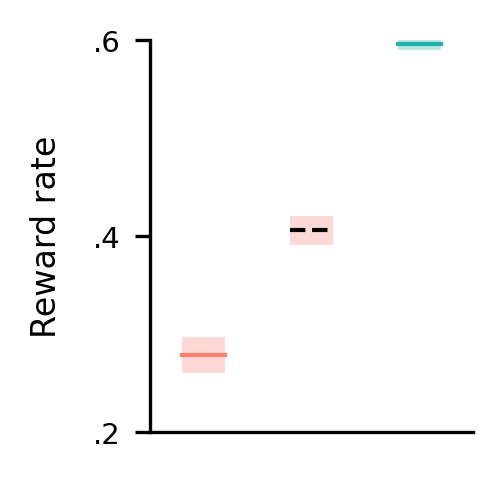

In [40]:
width = 1.5; height = 1.4
yticks = np.around(np.linspace(0.2, 0.6, 3), 1)

xticks = np.arange(3)

fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks([], fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Reward rate', fontsize=fontsize+1)
ax.set_xlim(xticks[0]-0.5, xticks[-1]+0.5)
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_label_coords(-0.27, 0.5)
ax.yaxis.set_major_formatter(major_formatter)

meandata = np.array([np.mean([df.rewarded.sum() / (np.sum([d.pos_x.size - 1 for d in df.itertuples()]) * arg.DT) 
                              for df in dfs]) for dfs in agent_trajectories_all_pert])
semdata = np.array([sem([df.rewarded.sum() / (np.sum([d.pos_x.size - 1 for d in df.itertuples()]) * arg.DT) 
                         for df in dfs]) for dfs in agent_trajectories_all_pert])


for x, ymean, ysem, c1, c2, ls in zip(xticks, meandata, semdata, colors1, colors2, ['-', '--', '-']):
    ax.plot([x-0.2, x+0.2], [ymean, ymean], c=c1, lw=lw, ls=ls)
    ax.fill_between([x-0.2, x+0.2], [ymean - ysem] * 2, [ymean + ysem] * 2, 
                    facecolor=c2, alpha=0.3)

fig.tight_layout(pad=0, rect=[0.015, 0, 1.015, 1])
#plt.savefig(figure_path / 'raw/{name}.pdf'.format(
#                 name='reward_rate_pert'), orientation='portrait', format='pdf', transparent=True)

In [41]:
targets = agent_trajectories_all_pert[0][0][['target_x', 'target_y']].values
shuffled_targets = targets.copy()
rng = default_rng(1); rng.shuffle(shuffled_targets, axis=0)

ydata_subjects = []; xdata_subjects = []
for dfs in agent_trajectories_all_pert:
    ydata_seeds = []; xdata_seeds = []
    for df in dfs:
        ydata = []; xdata = []
        dr = np.linalg.norm(df[['pos_x_end', 'pos_y_end']].values - targets, axis=1)
        dr_shuffled = np.linalg.norm(df[['pos_x_end', 'pos_y_end']].values - shuffled_targets, axis=1) 
        hypo_reward_boundaries = np.arange(round(max(max(dr), max(dr_shuffled))) + 2)
        for reward_boundary in hypo_reward_boundaries:
            ydata.append((dr < reward_boundary).sum() / len(df))
            xdata.append((dr_shuffled < reward_boundary).sum() / len(df))
        ydata_seeds.append(ydata); xdata_seeds.append(xdata)
    ydata_subjects.append(ydata_seeds); xdata_subjects.append(xdata_seeds)
    
    
auc_data_pert = [[np.trapz(ydata_subjects[agent_idx][idx], xdata_subjects[agent_idx][idx]) 
             for idx in range(len(agent_trajectories_all_pert[agent_idx]))] 
            for agent_idx in range(len(agent_trajectories_all_pert))]
auc_mean_pert = np.array([np.mean(i) for i in auc_data_pert])
auc_sem_pert = np.array([sem(i) for i in auc_data_pert])

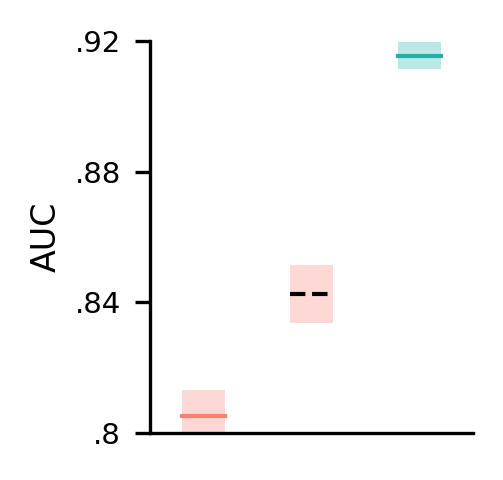

In [42]:
width = 1.5; height = 1.4
yticks = np.around(np.linspace(0.80, 0.92, 4), 2)

xticks = np.arange(3)

fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks([], fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('AUC', fontsize=fontsize+1)
ax.set_xlim(xticks[0]-0.5, xticks[-1]+0.5)
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_label_coords(-0.27, 0.5)
ax.yaxis.set_major_formatter(major_formatter)

for x, ymean, ysem, c1, c2, ls in zip(xticks, auc_mean_pert, auc_sem_pert, colors1, colors2, ['-', '--', '-']):
    ax.plot([x-0.2, x+0.2], [ymean, ymean], c=c1, lw=lw, ls=ls)
    ax.fill_between([x-0.2, x+0.2], [ymean - ysem] * 2, [ymean + ysem] * 2, 
                    facecolor=c2, alpha=0.3)

fig.tight_layout(pad=0, rect=[0.015, 0, 1.015, 1])
#plt.savefig(figure_path / 'raw/{name}.pdf'.format(
#                 name='AUC_pert'), orientation='portrait', format='pdf', transparent=True)

In [43]:
curvs_mean_pert = [np.mean([v.mean() for v in compute_curvature(agent_trajectories, stack_trials=True)]) 
              for agent_trajectories in agent_trajectories_all_pert]
curvs_sem_pert = [sem([v.mean() for v in compute_curvature(agent_trajectories, stack_trials=True)]) 
             for agent_trajectories in agent_trajectories_all_pert]

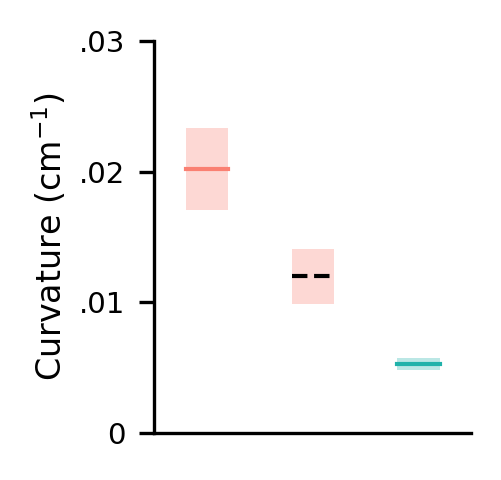

In [44]:
width = 1.5; height = 1.4
yticks = np.around(np.linspace(0, 0.03, 4), 3)

xticks = np.arange(3)

fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks([], fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Curvature (cm$^{-1}$)', fontsize=fontsize+1)
ax.set_xlim(xticks[0]-0.5, xticks[-1]+0.5)
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_label_coords(-0.27, 0.5)
ax.yaxis.set_major_formatter(major_formatter)

for x, ymean, ysem, c1, c2, ls in zip(xticks, curvs_mean_pert, curvs_sem_pert, colors1, colors2, ['-', '--', '-']):
    ax.plot([x-0.2, x+0.2], [ymean, ymean], c=c1, lw=lw, ls=ls)
    ax.fill_between([x-0.2, x+0.2], [ymean - ysem] * 2, [ymean + ysem] * 2, 
                    facecolor=c2, alpha=0.3)

fig.tight_layout(pad=0, rect=[0.015, 0, 1.015, 1])
#plt.savefig(figure_path / 'raw/{name}.pdf'.format(
#    name='curvature_pert'), orientation='portrait', format='pdf', transparent=True)

In [45]:
lengths_mean_pert = [np.mean([v.mean() for v in compute_length(agent_trajectories)]) 
              for agent_trajectories in agent_trajectories_all_pert]
lengths_sem_pert = [sem([v.mean() for v in compute_length(agent_trajectories)]) 
             for agent_trajectories in agent_trajectories_all_pert]

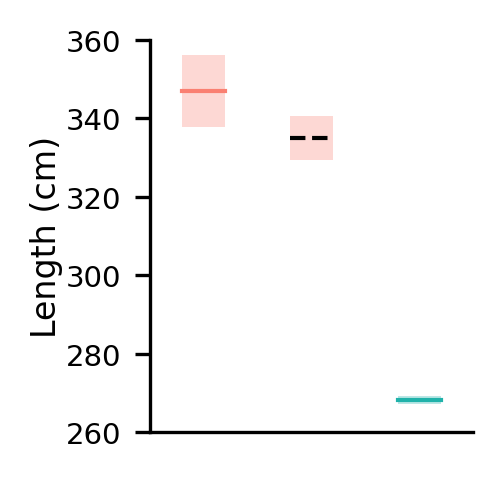

In [46]:
width = 1.5; height = 1.4
yticks = np.around(np.linspace(260, 360, 6), 0)

xticks = np.arange(3)

fig = plt.figure(figsize=(width, height), dpi=300)
ax = fig.add_subplot(111)
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
plt.xticks([], fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
ax.set_ylabel('Length (cm)', fontsize=fontsize+1)
ax.set_xlim(xticks[0]-0.5, xticks[-1]+0.5)
ax.set_ylim(yticks[0], yticks[-1])
ax.yaxis.set_label_coords(-0.27, 0.5)
ax.yaxis.set_major_formatter(major_formatter)

for x, ymean, ysem, c1, c2, ls in zip(xticks, lengths_mean_pert, lengths_sem_pert, colors1, colors2, ['-', '--', '-']):
    ax.plot([x-0.2, x+0.2], [ymean, ymean], c=c1, lw=lw, ls=ls)
    ax.fill_between([x-0.2, x+0.2], [ymean - ysem] * 2, [ymean + ysem] * 2, 
                    facecolor=c2, alpha=0.3)

fig.tight_layout(pad=0, rect=[0.015, 0, 1.015, 1])
#plt.savefig(figure_path / 'raw/{name}.pdf'.format(
#                 name='length_pert'), orientation='portrait', format='pdf', transparent=True)